# Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Cek Ditektori

In [3]:
# input_path = '/kaggle/input'
# for dirname, _, filenames in os.walk(input_path):
#     print(f"Folder: {dirname}")
#     for filename in filenames:
#         print(f"- {filename}")

# Persiapan Data

## Fungsi

In [4]:
def select_random_directories(base_dir, class_num):
    all_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    return random.sample(all_dirs, min(class_num, len(all_dirs)))

In [5]:
def load_video_data(class_dirs, sequence_length, frame_size):
    sequences = []
    labels = []
    label_map = {}

    for i, class_path in enumerate(class_dirs):
        class_name = os.path.basename(class_path)
        print(f"Processing class {i}: {class_name}")
        label_map[class_name] = i

        for video_name in os.listdir(class_path):
            video_path = os.path.join(class_path, video_name)
            sequence = process_video(video_path, sequence_length, frame_size)
            if sequence is not None:
                sequences.append(sequence)
                labels.append(i)

    return np.array(sequences), np.array(labels), label_map


In [6]:
def process_video(video_path, sequence_length, frame_size):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0
        frames.append(frame)

    cap.release()

    if len(frames) < sequence_length:
        return None

    if len(frames) > sequence_length:
        indices = np.linspace(0, len(frames) - 1, sequence_length, dtype=int)
        frames = [frames[i] for i in indices]

    return np.array(frames)

In [7]:
def augment_video(video_tensor):
    seed = tf.random.uniform(shape=(), maxval=10000, dtype=tf.int32)

    video_tensor = tf.image.stateless_random_flip_left_right(video_tensor, seed=[seed, seed])
    video_tensor = tf.image.stateless_random_brightness(video_tensor, max_delta=0.2, seed=[seed, seed])
    video_tensor = tf.image.stateless_random_contrast(video_tensor, lower=0.8, upper=1.2, seed=[seed, seed])
    return video_tensor

In [8]:
def train_val_split(X, y, val_size, batch_size, random_state=None, augment_fn = None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.arange(len(X))
    np.random.shuffle(indices)

    num_val = int(len(X) * val_size)
    train_indices, val_indices = indices[:-num_val], indices[-num_val:]

    def generator(indices):
        for idx in indices:
            yield X[idx], y[idx]

    # def generator(indices, augment=True):
    #     for idx in indices:
    #         video = X[idx]
    #         label = y[idx]
    #         if augment:
    #             video = augment_fn(video)
    #         yield video, label

    train_dataset = tf.data.Dataset.from_generator(
        lambda: generator(train_indices),
        output_signature=(tf.TensorSpec(shape=X.shape[1:], dtype=tf.float32),
                          tf.TensorSpec(shape=y.shape[1:], dtype=tf.float32))
    )
    val_dataset = tf.data.Dataset.from_generator(
        lambda: generator(val_indices),
        output_signature=(tf.TensorSpec(shape=X.shape[1:], dtype=tf.float32),
                          tf.TensorSpec(shape=y.shape[1:], dtype=tf.float32))
    )

    train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

In [9]:
def get_random_video_info(data, num_samples=5):
    X, y = data
    video_info = []
    
    random_indices = random.sample(range(len(X)), num_samples)
    
    for idx in random_indices:
        video = X[idx]
        label = y[idx]
        
        video_length = len(video)
        frame_size = video.shape[1:]
        class_label = label
        
        first_frame = video[0]
        frame_shape = first_frame.shape
        
        video_info.append({
            'video_index': idx,
            'video_length': video_length,
            'frame_size': frame_size,
            'first_frame_shape': frame_shape,
            'label': class_label
        })
    
    return video_info

## Variabel

In [10]:
BASE_DIR = '/kaggle/input/dataset/SL/'
CLASS_NUM = 50

SEQUENCE_LENGTH = 60
FRAME_SIZE = (224, 224)

VAL_SIZE = 0.2
RANDOM_SEED = 21

BATCH_SIZE = 1
BUFFER_SIZE = 1000

LABEL_LIST = []

## Proses

In [11]:
class_dirs = select_random_directories(BASE_DIR, CLASS_NUM)

In [12]:
X, y, label_map = load_video_data(class_dirs, SEQUENCE_LENGTH, FRAME_SIZE)

Processing class 0: spoon
Processing class 1: theater
Processing class 2: repeat
Processing class 3: pet
Processing class 4: recognize
Processing class 5: orange
Processing class 6: sausage
Processing class 7: mine
Processing class 8: invite
Processing class 9: goodbye
Processing class 10: fail
Processing class 11: approve
Processing class 12: moon
Processing class 13: ticket
Processing class 14: bet
Processing class 15: apartment
Processing class 16: bully
Processing class 17: gymnastics
Processing class 18: seldom
Processing class 19: find
Processing class 20: rose
Processing class 21: punish
Processing class 22: bored
Processing class 23: individual
Processing class 24: lemon
Processing class 25: pig
Processing class 26: south america
Processing class 27: classroom
Processing class 28: broke
Processing class 29: fact
Processing class 30: network
Processing class 31: lady
Processing class 32: second
Processing class 33: excited
Processing class 34: work
Processing class 35: sue
Proce

In [13]:
video_info = get_random_video_info((X, y))
for info in video_info:
    print(f"Video Index: {info['video_index']}")
    print(f"Video Length: {info['video_length']} frames")
    print(f"Frame Size: {info['frame_size']}")
    print(f"First Frame Shape: {info['first_frame_shape']}")
    print(f"Label: {info['label']}")
    print("-" * 50)

Video Index: 156
Video Length: 60 frames
Frame Size: (224, 224, 3)
First Frame Shape: (224, 224, 3)
Label: 41
--------------------------------------------------
Video Index: 128
Video Length: 60 frames
Frame Size: (224, 224, 3)
First Frame Shape: (224, 224, 3)
Label: 33
--------------------------------------------------
Video Index: 177
Video Length: 60 frames
Frame Size: (224, 224, 3)
First Frame Shape: (224, 224, 3)
Label: 47
--------------------------------------------------
Video Index: 117
Video Length: 60 frames
Frame Size: (224, 224, 3)
First Frame Shape: (224, 224, 3)
Label: 30
--------------------------------------------------
Video Index: 31
Video Length: 60 frames
Frame Size: (224, 224, 3)
First Frame Shape: (224, 224, 3)
Label: 8
--------------------------------------------------


In [14]:
train_dataset, val_dataset = train_val_split(X, y, VAL_SIZE, BATCH_SIZE, RANDOM_SEED, augment_video)

# Pelatihan Model

## Fungsi

In [15]:
def create_model(class_num, sequence_length, frame_size):
    inputs = layers.Input(shape=(sequence_length, *frame_size, 3))
    
    x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='valid')(inputs)
    # x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    # x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    # x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    # x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='valid')(x)
    # x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(96, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    outputs = layers.Dense(class_num, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [16]:
def train_model(model, train_dataset, val_dataset, batch_size, epochs):
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=5e-2),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[
            # tf.keras.callbacks.EarlyStopping(
            #     monitor='val_loss',
            #     patience=7,
            #     restore_best_weights=True
            # ),
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor='val_loss',
            #     factor=0.5,
            #     patience=3,
            #     min_lr=1e-6
            # )
        ]
    )

    return history

In [17]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.plot(loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Variabel

In [18]:
EPOCHS = 30

## Proses

In [19]:
model = create_model(CLASS_NUM, SEQUENCE_LENGTH, FRAME_SIZE)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 58, 222, 222,   │         1,312 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 29, 111, 111,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 111, 111,   │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 27, 109, 109,   │        13,856 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 13, 54, 54, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 54, 54, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 11, 52, 52, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 5, 26, 26, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 26, 26, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 24, 24, 32)  │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 24, 24, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 55296)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     5,308,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         4,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,383,890 (20.54 MB)

 Trainable params: 5,383,890 (20.54 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = train_model(model, train_dataset, val_dataset, BATCH_SIZE, EPOCHS)

Epoch 1/30


I0000 00:00:1733844908.671694    1356 service.cc:145] XLA service 0x78f42800cf70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733844908.671777    1356 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733844908.671783    1356 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-10 15:35:17.360146: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=0,k3=0} for conv (f32[16,3,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,60,224,224]{4,3,2,1,0}, f32[1,16,58,222,222]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-10 15:35:17.810517: E externa

      1/Unknown 18s 18s/step - accuracy: 0.0000e+00 - loss: 4.1330

I0000 00:00:1733844924.238854    1356 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    152/Unknown 31s 87ms/step - accuracy: 0.0071 - loss: 3.9915

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


152/152 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step - accuracy: 0.0071 - loss: 3.9911 - val_accuracy: 0.0000e+00 - val_loss: 3.9134
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.0311 - loss: 3.9193 - val_accuracy: 0.0000e+00 - val_loss: 3.9128
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.0148 - loss: 3.9052 - val_accuracy: 0.0000e+00 - val_loss: 3.9113
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 110ms/step - accuracy: 0.0329 - loss: 3.9146 - val_accuracy: 0.0000e+00 - val_loss: 3.9109
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.0298 - loss: 3.9079 - val_accuracy: 0.0263 - val_loss: 3.9193
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.0435 - loss: 3.8872 - val_accuracy: 0.0526 - val_loss: 3.9110
Epoch 7/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.0709 - loss: 3.7392 - val_accuracy: 0.0789 - val_loss: 3.9056
Epoch 8/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.0662 - lo

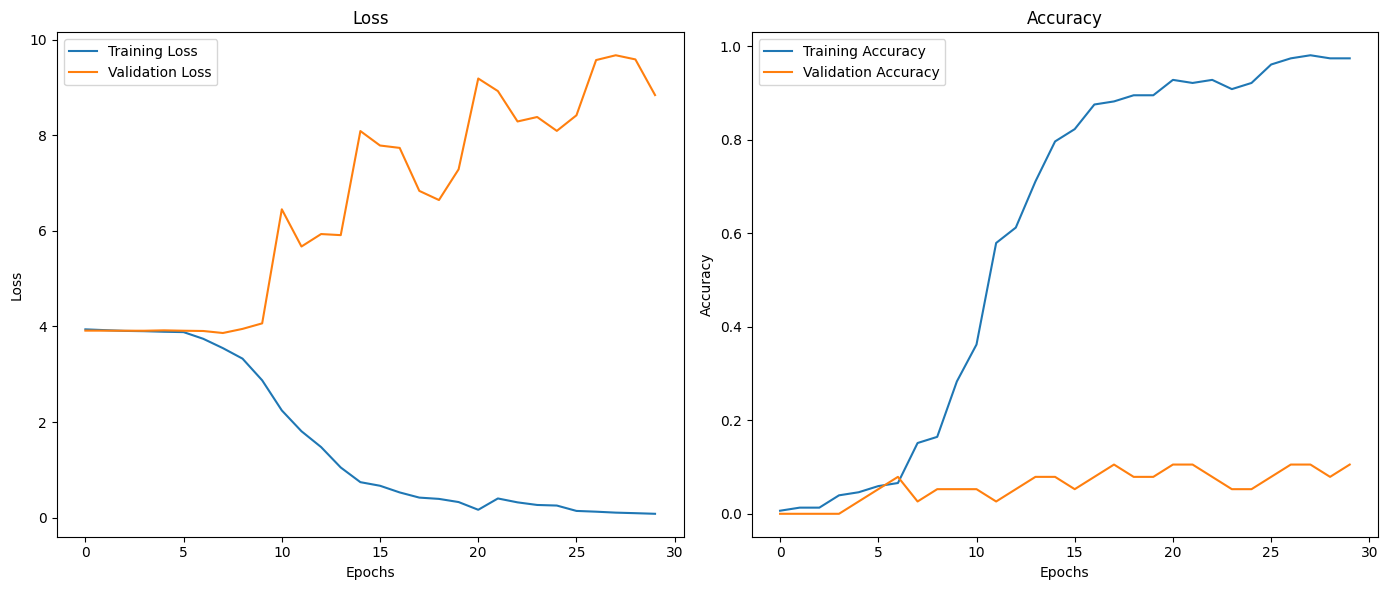

In [21]:
plot_history(history)

In [22]:
model.save("sign_language_video_model.h5")

In [23]:
print(label_map)

{'spoon': 0, 'theater': 1, 'repeat': 2, 'pet': 3, 'recognize': 4, 'orange': 5, 'sausage': 6, 'mine': 7, 'invite': 8, 'goodbye': 9, 'fail': 10, 'approve': 11, 'moon': 12, 'ticket': 13, 'bet': 14, 'apartment': 15, 'bully': 16, 'gymnastics': 17, 'seldom': 18, 'find': 19, 'rose': 20, 'punish': 21, 'bored': 22, 'individual': 23, 'lemon': 24, 'pig': 25, 'south america': 26, 'classroom': 27, 'broke': 28, 'fact': 29, 'network': 30, 'lady': 31, 'second': 32, 'excited': 33, 'work': 34, 'sue': 35, 'statistics': 36, 'seem': 37, 'cuba': 38, 'gift': 39, 'question': 40, 'engagement': 41, 'inspect': 42, 'blend': 43, 'sad': 44, 'heavy': 45, 'sentence': 46, 'weight': 47, 'center': 48, 'pumpkin': 49}
